## VAE Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super().__init__()

#         self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.input = nn.Linear(input_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)

#     def forward(self, x, label):
    def forward(self, x):
#         out = self.input(torch.cat((x, label), -1))
        out = self.input(x)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.hidden2(out)
#         out = F.relu(out)
        
#         out = self.hidden3(out)
#         out = F.relu(out)
        
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)

        return mu_z, std_z


class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim, output_dim):
        super().__init__()

#         self.input = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.input = nn.Linear(latent_dim, hidden_dim)
#         self.bn = nn.BatchNorm1d(hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.2)
        
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout3 = nn.Dropout(0.5)
        
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z, label):
    def forward(self, z):
#         out = self.input(torch.cat((z, label), -1))
        out = self.input(z)

        out = self.hidden(out)
        out = self.bn1(out)
        out = F.relu(out)
#         out = self.dropout1(out)
        
#         out = self.hidden2(out)
#         out = F.relu(out)
        
#         out = self.hidden3(out)
# #         out = self.bn3(out)
#         out = F.relu(out)
# #         out = self.dropout3(out)
        
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)

        return mu_x, std_x

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import torch 
import pandas as pd 
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [3]:
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
print(len(bos.feature_names))
df["Price"] = bos.target

data = df[df.columns[:-1]]
# data = data.apply(
#     lambda x: (x - x.mean()) / x.std()
# )

data["Price"] = df.Price

13


In [4]:
from sklearn import preprocessing

# Dataset to numpy
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64)

# Split dataset for test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=42)

# Standardize 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

Y_train = Y_train.view(-1, 1)
Y_test = Y_test.view(-1, 1)

In [5]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [6]:
""" Hyperparameters """
N_EPOCHS = 1200    # N_EPOCHS = 100 overfitted the data so the evaluation was very bad 
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X_train.shape[1]
LABEL_DIM = Y_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 5

In [7]:
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)

In [8]:
encoder = Encoder(INPUT_DIM, LABEL_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
decoder = Decoder(LATENT_DIM, LABEL_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=1e-7)

In [10]:
train_loss_avg = []
test_losses = []


for ep in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x, y in train_iter:
        # Update the gradient to zero 
        optimizer.zero_grad()
        
        # Forward pass 
        # Encoder
#         mu_z, std_z = encoder(x, y)
        mu_z, std_z = encoder(x)

        # Sample z
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)

        # Decoder
#         mu_x, std_x = decoder(z_samples, y)
        mu_x, std_x = decoder(z_samples)
        eps = torch.randn_like(std_x)

#         x_samples = mu_x + eps * torch.exp(std_x)

#         return mu_z, std_z, z_samples, mu_x, std_x, x_samples
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward pass 
        loss.backward()
        
        # Update the weights 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
    
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    
    mu_z, std_z = encoder(X_test)
    
    eps = torch.randn_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)

    mu_x, std_x = decoder(z_samples)
    eps = torch.randn_like(std_x)

    loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, X_test)

    test_losses.append(loss.item())
    
    print("Epoch [%d / %d] average loss: %f" % (ep+1, N_EPOCHS, train_loss_avg[-1]))
    print("Epoch [%d / %d] test loss: %f" % (ep+1, N_EPOCHS, test_losses[-1]))

Epoch [1 / 1200] average loss: 26.406805
Epoch [1 / 1200] test loss: 25.763205
Epoch [2 / 1200] average loss: 25.597570
Epoch [2 / 1200] test loss: 24.809198
Epoch [3 / 1200] average loss: 24.051956
Epoch [3 / 1200] test loss: 24.343946
Epoch [4 / 1200] average loss: 23.603130
Epoch [4 / 1200] test loss: 24.662345
Epoch [5 / 1200] average loss: 25.084145
Epoch [5 / 1200] test loss: 26.193193
Epoch [6 / 1200] average loss: 23.519565
Epoch [6 / 1200] test loss: 23.771573
Epoch [7 / 1200] average loss: 23.498981
Epoch [7 / 1200] test loss: 23.848869
Epoch [8 / 1200] average loss: 22.829448
Epoch [8 / 1200] test loss: 23.275625
Epoch [9 / 1200] average loss: 23.026310
Epoch [9 / 1200] test loss: 22.294343
Epoch [10 / 1200] average loss: 22.744145
Epoch [10 / 1200] test loss: 22.006438
Epoch [11 / 1200] average loss: 22.425819
Epoch [11 / 1200] test loss: 22.195646
Epoch [12 / 1200] average loss: 22.202456
Epoch [12 / 1200] test loss: 22.596498
Epoch [13 / 1200] average loss: 21.925766
Epoc

Epoch [110 / 1200] average loss: 16.046342
Epoch [110 / 1200] test loss: 16.088640
Epoch [111 / 1200] average loss: 16.014877
Epoch [111 / 1200] test loss: 16.061163
Epoch [112 / 1200] average loss: 15.989363
Epoch [112 / 1200] test loss: 15.851156
Epoch [113 / 1200] average loss: 15.910479
Epoch [113 / 1200] test loss: 15.763716
Epoch [114 / 1200] average loss: 15.844912
Epoch [114 / 1200] test loss: 15.799000
Epoch [115 / 1200] average loss: 15.952948
Epoch [115 / 1200] test loss: 15.753898
Epoch [116 / 1200] average loss: 15.780200
Epoch [116 / 1200] test loss: 15.704410
Epoch [117 / 1200] average loss: 15.769909
Epoch [117 / 1200] test loss: 15.576069
Epoch [118 / 1200] average loss: 15.692344
Epoch [118 / 1200] test loss: 15.561749
Epoch [119 / 1200] average loss: 15.689857
Epoch [119 / 1200] test loss: 15.392739
Epoch [120 / 1200] average loss: 15.805028
Epoch [120 / 1200] test loss: 15.319826
Epoch [121 / 1200] average loss: 15.543480
Epoch [121 / 1200] test loss: 15.561153
Epoc

Epoch [219 / 1200] average loss: 11.924313
Epoch [219 / 1200] test loss: 11.410409
Epoch [220 / 1200] average loss: 11.798860
Epoch [220 / 1200] test loss: 11.279951
Epoch [221 / 1200] average loss: 11.826705
Epoch [221 / 1200] test loss: 11.589932
Epoch [222 / 1200] average loss: 11.941057
Epoch [222 / 1200] test loss: 11.365037
Epoch [223 / 1200] average loss: 11.678703
Epoch [223 / 1200] test loss: 11.374511
Epoch [224 / 1200] average loss: 11.673032
Epoch [224 / 1200] test loss: 11.404939
Epoch [225 / 1200] average loss: 11.724422
Epoch [225 / 1200] test loss: 11.372659
Epoch [226 / 1200] average loss: 11.685221
Epoch [226 / 1200] test loss: 11.392373
Epoch [227 / 1200] average loss: 11.683221
Epoch [227 / 1200] test loss: 11.099400
Epoch [228 / 1200] average loss: 11.613379
Epoch [228 / 1200] test loss: 11.182698
Epoch [229 / 1200] average loss: 11.590575
Epoch [229 / 1200] test loss: 11.260294
Epoch [230 / 1200] average loss: 11.641959
Epoch [230 / 1200] test loss: 11.415808
Epoc

Epoch [325 / 1200] average loss: 9.721665
Epoch [325 / 1200] test loss: 9.368829
Epoch [326 / 1200] average loss: 9.702447
Epoch [326 / 1200] test loss: 9.490867
Epoch [327 / 1200] average loss: 9.848855
Epoch [327 / 1200] test loss: 9.382747
Epoch [328 / 1200] average loss: 9.731309
Epoch [328 / 1200] test loss: 9.182414
Epoch [329 / 1200] average loss: 9.731409
Epoch [329 / 1200] test loss: 9.347967
Epoch [330 / 1200] average loss: 9.850722
Epoch [330 / 1200] test loss: 9.267140
Epoch [331 / 1200] average loss: 9.973053
Epoch [331 / 1200] test loss: 9.271336
Epoch [332 / 1200] average loss: 9.854521
Epoch [332 / 1200] test loss: 9.267374
Epoch [333 / 1200] average loss: 9.741387
Epoch [333 / 1200] test loss: 9.335008
Epoch [334 / 1200] average loss: 9.625674
Epoch [334 / 1200] test loss: 9.313498
Epoch [335 / 1200] average loss: 9.718443
Epoch [335 / 1200] test loss: 9.217295
Epoch [336 / 1200] average loss: 9.663107
Epoch [336 / 1200] test loss: 9.317610
Epoch [337 / 1200] average l

Epoch [431 / 1200] average loss: 8.606129
Epoch [431 / 1200] test loss: 8.261577
Epoch [432 / 1200] average loss: 8.548676
Epoch [432 / 1200] test loss: 8.122894
Epoch [433 / 1200] average loss: 8.509541
Epoch [433 / 1200] test loss: 8.231516
Epoch [434 / 1200] average loss: 8.554545
Epoch [434 / 1200] test loss: 8.118161
Epoch [435 / 1200] average loss: 8.574913
Epoch [435 / 1200] test loss: 8.146538
Epoch [436 / 1200] average loss: 8.758929
Epoch [436 / 1200] test loss: 8.172457
Epoch [437 / 1200] average loss: 8.672190
Epoch [437 / 1200] test loss: 8.179271
Epoch [438 / 1200] average loss: 8.793991
Epoch [438 / 1200] test loss: 8.114467
Epoch [439 / 1200] average loss: 8.529751
Epoch [439 / 1200] test loss: 8.050433
Epoch [440 / 1200] average loss: 8.609687
Epoch [440 / 1200] test loss: 8.114097
Epoch [441 / 1200] average loss: 8.457328
Epoch [441 / 1200] test loss: 8.056855
Epoch [442 / 1200] average loss: 8.514858
Epoch [442 / 1200] test loss: 8.073151
Epoch [443 / 1200] average l

Epoch [536 / 1200] average loss: 7.565980
Epoch [536 / 1200] test loss: 7.077388
Epoch [537 / 1200] average loss: 7.560024
Epoch [537 / 1200] test loss: 7.185919
Epoch [538 / 1200] average loss: 7.669265
Epoch [538 / 1200] test loss: 7.311769
Epoch [539 / 1200] average loss: 7.679624
Epoch [539 / 1200] test loss: 7.289725
Epoch [540 / 1200] average loss: 7.702176
Epoch [540 / 1200] test loss: 7.046300
Epoch [541 / 1200] average loss: 7.739564
Epoch [541 / 1200] test loss: 7.129313
Epoch [542 / 1200] average loss: 7.497228
Epoch [542 / 1200] test loss: 7.106944
Epoch [543 / 1200] average loss: 7.609491
Epoch [543 / 1200] test loss: 7.305501
Epoch [544 / 1200] average loss: 7.710712
Epoch [544 / 1200] test loss: 7.011989
Epoch [545 / 1200] average loss: 7.654284
Epoch [545 / 1200] test loss: 7.164341
Epoch [546 / 1200] average loss: 7.610071
Epoch [546 / 1200] test loss: 7.020277
Epoch [547 / 1200] average loss: 7.628732
Epoch [547 / 1200] test loss: 7.274973
Epoch [548 / 1200] average l

Epoch [641 / 1200] average loss: 6.848756
Epoch [641 / 1200] test loss: 6.543563
Epoch [642 / 1200] average loss: 6.666106
Epoch [642 / 1200] test loss: 6.556949
Epoch [643 / 1200] average loss: 6.687046
Epoch [643 / 1200] test loss: 6.505660
Epoch [644 / 1200] average loss: 6.732792
Epoch [644 / 1200] test loss: 6.739493
Epoch [645 / 1200] average loss: 6.713023
Epoch [645 / 1200] test loss: 6.579245
Epoch [646 / 1200] average loss: 6.790302
Epoch [646 / 1200] test loss: 6.590545
Epoch [647 / 1200] average loss: 6.751229
Epoch [647 / 1200] test loss: 6.578730
Epoch [648 / 1200] average loss: 6.759753
Epoch [648 / 1200] test loss: 6.453224
Epoch [649 / 1200] average loss: 6.731913
Epoch [649 / 1200] test loss: 6.473056
Epoch [650 / 1200] average loss: 6.789664
Epoch [650 / 1200] test loss: 6.521967
Epoch [651 / 1200] average loss: 6.869135
Epoch [651 / 1200] test loss: 6.621005
Epoch [652 / 1200] average loss: 6.747027
Epoch [652 / 1200] test loss: 6.528705
Epoch [653 / 1200] average l

Epoch [748 / 1200] average loss: 6.430840
Epoch [748 / 1200] test loss: 6.515691
Epoch [749 / 1200] average loss: 6.315801
Epoch [749 / 1200] test loss: 6.296253
Epoch [750 / 1200] average loss: 6.324965
Epoch [750 / 1200] test loss: 6.392369
Epoch [751 / 1200] average loss: 6.432646
Epoch [751 / 1200] test loss: 6.536420
Epoch [752 / 1200] average loss: 6.316134
Epoch [752 / 1200] test loss: 6.316048
Epoch [753 / 1200] average loss: 6.306808
Epoch [753 / 1200] test loss: 6.327845
Epoch [754 / 1200] average loss: 6.336710
Epoch [754 / 1200] test loss: 6.338736
Epoch [755 / 1200] average loss: 6.268615
Epoch [755 / 1200] test loss: 6.387060
Epoch [756 / 1200] average loss: 6.313928
Epoch [756 / 1200] test loss: 6.526678
Epoch [757 / 1200] average loss: 6.331869
Epoch [757 / 1200] test loss: 6.480349
Epoch [758 / 1200] average loss: 6.407717
Epoch [758 / 1200] test loss: 6.432285
Epoch [759 / 1200] average loss: 6.528126
Epoch [759 / 1200] test loss: 6.489179
Epoch [760 / 1200] average l

Epoch [860 / 1200] average loss: 6.264267
Epoch [860 / 1200] test loss: 6.283508
Epoch [861 / 1200] average loss: 6.739893
Epoch [861 / 1200] test loss: 6.388545
Epoch [862 / 1200] average loss: 6.501234
Epoch [862 / 1200] test loss: 6.560224
Epoch [863 / 1200] average loss: 6.519064
Epoch [863 / 1200] test loss: 6.403789
Epoch [864 / 1200] average loss: 6.175553
Epoch [864 / 1200] test loss: 6.606452
Epoch [865 / 1200] average loss: 6.279965
Epoch [865 / 1200] test loss: 6.335004
Epoch [866 / 1200] average loss: 6.244769
Epoch [866 / 1200] test loss: 6.394620
Epoch [867 / 1200] average loss: 6.477081
Epoch [867 / 1200] test loss: 6.539202
Epoch [868 / 1200] average loss: 6.134612
Epoch [868 / 1200] test loss: 6.372728
Epoch [869 / 1200] average loss: 6.165430
Epoch [869 / 1200] test loss: 6.141957
Epoch [870 / 1200] average loss: 6.093778
Epoch [870 / 1200] test loss: 6.472972
Epoch [871 / 1200] average loss: 6.123723
Epoch [871 / 1200] test loss: 6.373996
Epoch [872 / 1200] average l

Epoch [969 / 1200] average loss: 6.040204
Epoch [969 / 1200] test loss: 6.114875
Epoch [970 / 1200] average loss: 5.930102
Epoch [970 / 1200] test loss: 6.320089
Epoch [971 / 1200] average loss: 6.162514
Epoch [971 / 1200] test loss: 6.172233
Epoch [972 / 1200] average loss: 6.013788
Epoch [972 / 1200] test loss: 6.174318
Epoch [973 / 1200] average loss: 6.092151
Epoch [973 / 1200] test loss: 5.774138
Epoch [974 / 1200] average loss: 5.912786
Epoch [974 / 1200] test loss: 6.170780
Epoch [975 / 1200] average loss: 6.022034
Epoch [975 / 1200] test loss: 6.154656
Epoch [976 / 1200] average loss: 5.759540
Epoch [976 / 1200] test loss: 5.994872
Epoch [977 / 1200] average loss: 5.868190
Epoch [977 / 1200] test loss: 6.039385
Epoch [978 / 1200] average loss: 5.869390
Epoch [978 / 1200] test loss: 6.287345
Epoch [979 / 1200] average loss: 5.799627
Epoch [979 / 1200] test loss: 6.127980
Epoch [980 / 1200] average loss: 5.835467
Epoch [980 / 1200] test loss: 6.056859
Epoch [981 / 1200] average l

Epoch [1076 / 1200] average loss: 5.781813
Epoch [1076 / 1200] test loss: 6.066668
Epoch [1077 / 1200] average loss: 5.823567
Epoch [1077 / 1200] test loss: 5.723870
Epoch [1078 / 1200] average loss: 5.625996
Epoch [1078 / 1200] test loss: 6.116089
Epoch [1079 / 1200] average loss: 5.779135
Epoch [1079 / 1200] test loss: 5.789840
Epoch [1080 / 1200] average loss: 5.765366
Epoch [1080 / 1200] test loss: 5.931943
Epoch [1081 / 1200] average loss: 5.797360
Epoch [1081 / 1200] test loss: 5.915856
Epoch [1082 / 1200] average loss: 5.661688
Epoch [1082 / 1200] test loss: 5.878162
Epoch [1083 / 1200] average loss: 5.677624
Epoch [1083 / 1200] test loss: 6.006619
Epoch [1084 / 1200] average loss: 5.680047
Epoch [1084 / 1200] test loss: 6.002596
Epoch [1085 / 1200] average loss: 5.707266
Epoch [1085 / 1200] test loss: 5.853659
Epoch [1086 / 1200] average loss: 5.691774
Epoch [1086 / 1200] test loss: 6.029968
Epoch [1087 / 1200] average loss: 5.664143
Epoch [1087 / 1200] test loss: 5.820618
Epoc

Epoch [1179 / 1200] average loss: 5.649404
Epoch [1179 / 1200] test loss: 6.044581
Epoch [1180 / 1200] average loss: 5.746161
Epoch [1180 / 1200] test loss: 5.817303
Epoch [1181 / 1200] average loss: 5.662461
Epoch [1181 / 1200] test loss: 5.911813
Epoch [1182 / 1200] average loss: 5.600483
Epoch [1182 / 1200] test loss: 6.059882
Epoch [1183 / 1200] average loss: 5.726807
Epoch [1183 / 1200] test loss: 5.819301
Epoch [1184 / 1200] average loss: 5.648748
Epoch [1184 / 1200] test loss: 6.238085
Epoch [1185 / 1200] average loss: 5.726874
Epoch [1185 / 1200] test loss: 5.862664
Epoch [1186 / 1200] average loss: 5.556676
Epoch [1186 / 1200] test loss: 5.894049
Epoch [1187 / 1200] average loss: 5.719585
Epoch [1187 / 1200] test loss: 5.913746
Epoch [1188 / 1200] average loss: 5.599201
Epoch [1188 / 1200] test loss: 5.727123
Epoch [1189 / 1200] average loss: 5.661499
Epoch [1189 / 1200] test loss: 5.938106
Epoch [1190 / 1200] average loss: 5.542627
Epoch [1190 / 1200] test loss: 5.928069
Epoc

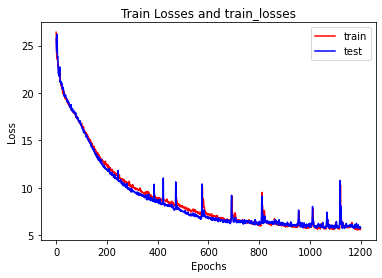

In [44]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg, 'r')
plt.plot(test_losses, 'b')
plt.legend(["train", "test"])
plt.title("Train Losses and train_losses")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Loss function 
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log q_\theta(z|x_i) - \log p_\phi(x_i|z) - \log p(z)]\\
= -\frac{1}{S} \sum_{i=1}^S [\mathcal{N}(z|\mu(x_i), \sigma(x_i))- \mathcal{N}(x_i|\mu(z), \sigma(z)) - \mathcal{N}(z|0, 1)]
$$
We add a negative sign to the loss function because the lower bound should be maximized while the loss function should be minimized.

### Test evaluation metrics
$$
\log p(x_i) \geq \int q_\theta(z|x_i) [\log p_\phi(x_i|z) + \log p(z) - \log q_\theta(z|x_i)] dz\\
\approx - \frac{1}{S} \sum_{i=1}^{S} [\log p_\phi(x_i|z)]\\
$$


Should I set $q_\theta(z|x_i)$ to $\mathcal{N}(z|0,1)$ if I am testing with $z\sim q(z)$? So the test evaluation would just be on the term $\log p_\phi(x_i|z)$.
I will be using my trained cVAE for predicting $x$ given just the label. It make sense to test in an environment same as how I will be using the model. So I should just find the error caused by the decoder. 

Referenced for loss function:
https://medium.com/retina-ai-health-inc/variational-inference-derivation-of-the-variational-autoencoder-vae-loss-function-a-true-story-3543a3dc67ee

Tutorial referenced:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb#scrollTo=LKnr0LCMhEGj

In [13]:
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [14]:
def eval_metrics(mu_x, std_x, x_in):
    S = x_in.shape[0]
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x_in)
    
    loss = - (1 / S) * (torch.sum(log_p_x))
    
    return loss 

Sampling

In [15]:
S = X_test.shape[0]
# # Forward pass 
p_z_given_x = torch.distributions.Normal(0, 1)
z = p_z_given_x.sample((S, LATENT_DIM)).type(torch.float64)
# mu_x, std_x = decoder(z, Y_test)   
mu_x, std_x = decoder(z)

In [16]:
eps = torch.distributions.Normal(0, 1).sample(std_x.shape)
x_samples = mu_x + std_x * eps

In [17]:
x_samples.mean(0)

tensor([-0.0592, -0.3281, -0.3686,  0.0041,  0.1082, -0.0406,  0.0189, -0.1329,
        -0.1419,  0.3079,  0.1013,  0.0218,  0.1498], dtype=torch.float64,
       grad_fn=<MeanBackward1>)

In [18]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [19]:
x_samples.std(0)

tensor([3.2353, 3.5548, 3.3342, 0.1954, 1.4869, 0.5396, 1.3594, 1.4423, 1.9836,
        1.9177, 1.7650, 1.7213, 1.0910], dtype=torch.float64,
       grad_fn=<StdBackward1>)

In [20]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

Text(0, 0.5, 'Mean of Generated Distribution')

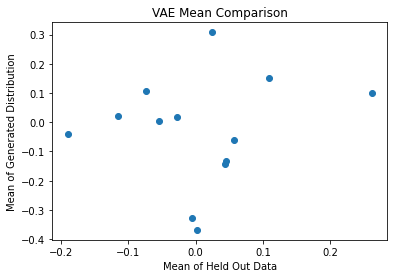

In [21]:
plt.scatter(X_test.mean(0).detach().numpy(), x_samples.mean(0).detach().numpy())
plt.title("VAE Mean Comparison")
plt.xlabel("Mean of Held Out Data")
plt.ylabel("Mean of Generated Distribution")

Text(0, 0.5, 'Standard Deviation of Generated Distribution')

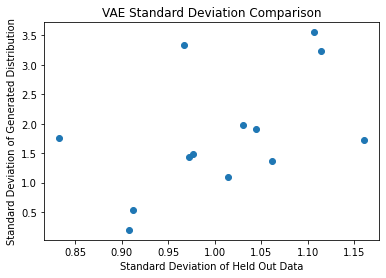

In [22]:
plt.scatter(X_test.std(0).detach().numpy(), x_samples.std(0).detach().numpy())
plt.title("VAE Standard Deviation Comparison")
plt.xlabel("Standard Deviation of Held Out Data")
plt.ylabel("Standard Deviation of Generated Distribution")

In [23]:
# figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
# for i in range(x_samples.shape[1]):
#     axs[i].scatter([x_test[:,i], x_samples[:,i]], color=['red','green'])
#     axs[i].legend(["data", "sample"])
# plt.show()

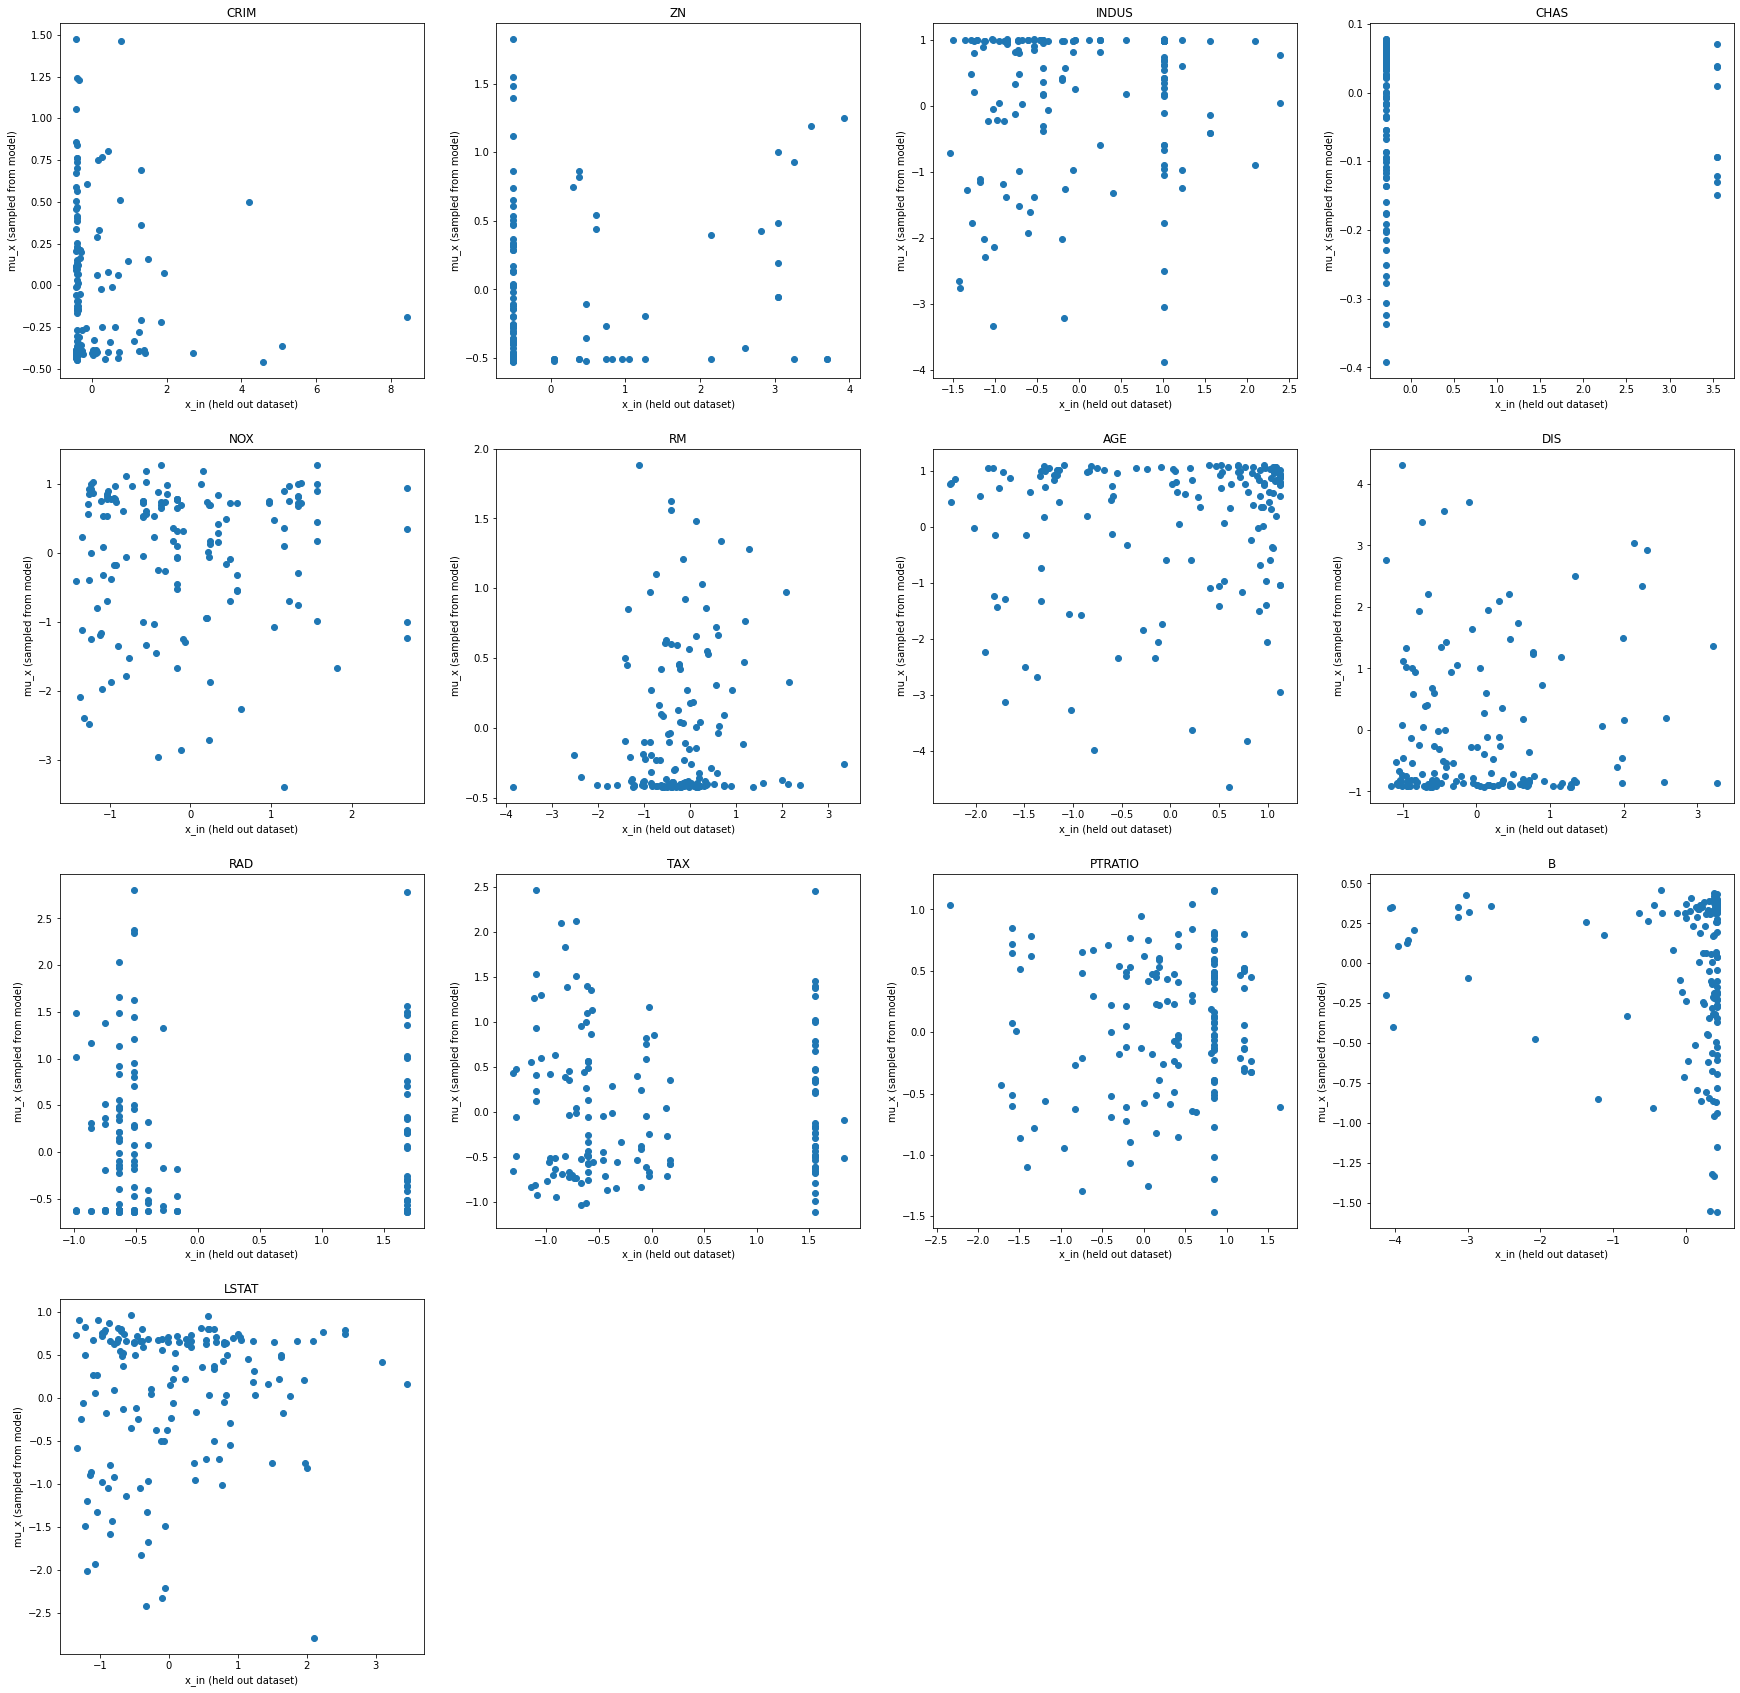

In [24]:
x_test = X_test.detach().numpy()
mu_x = mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(x_test[:,i*4+j], mu_x[:,i*4+j])
        axs[i, j].set_title(bos.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (sampled from model)")
        axs[i, j].set_xlabel("x_in (held out dataset)")
    if i*4+j >= 13: 
        break 

plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [25]:
X_test.shape

torch.Size([152, 13])

In [26]:
x_samples.shape

torch.Size([152, 13])

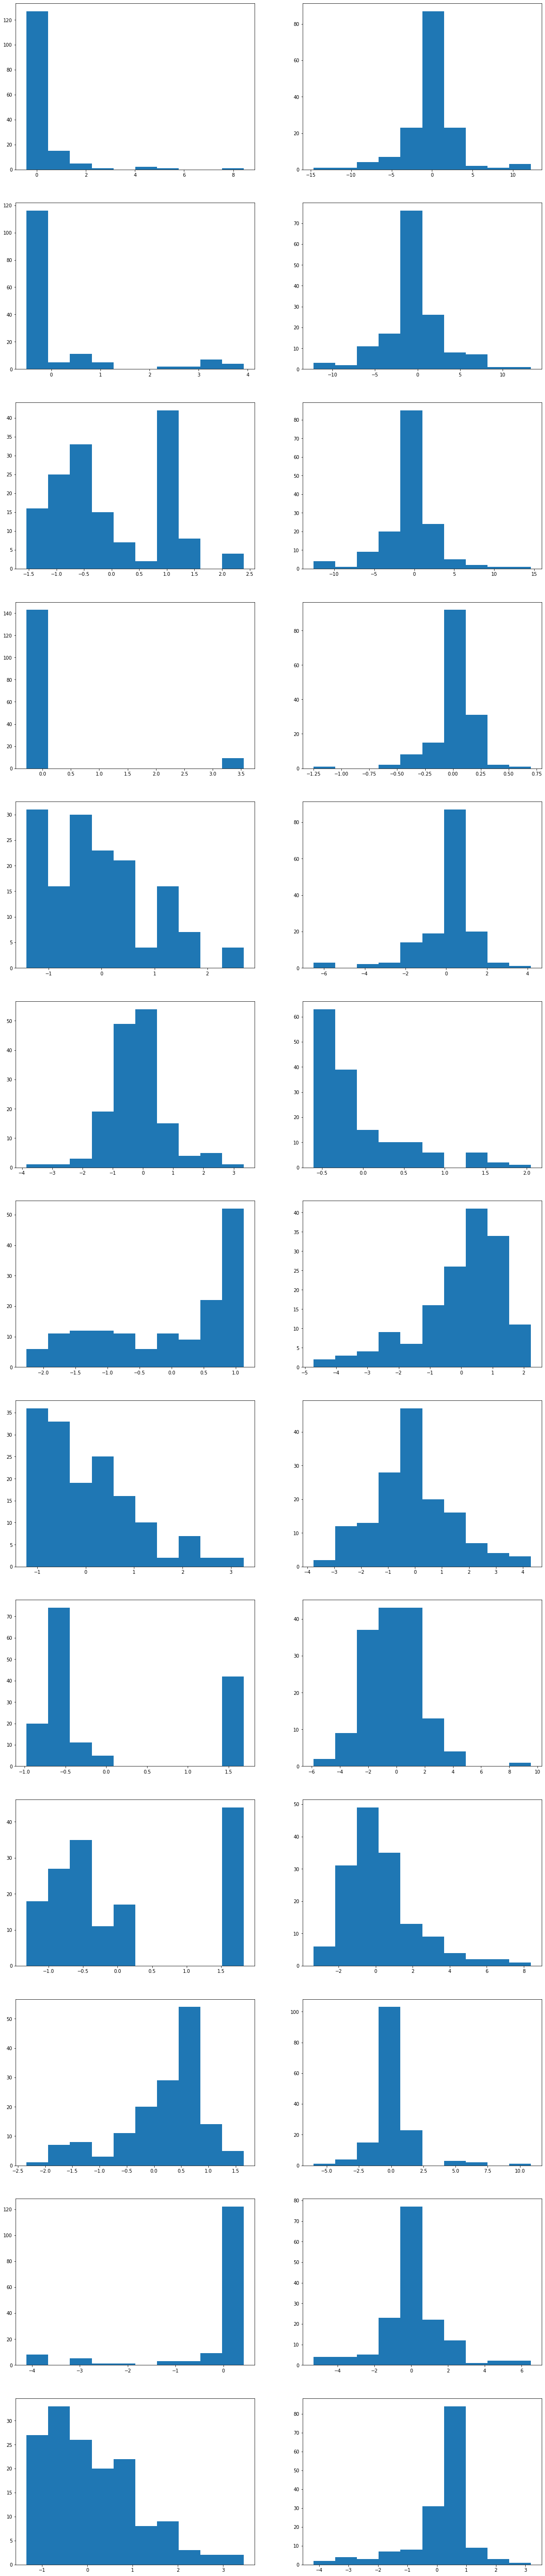

In [27]:
x_samples = x_samples.detach().numpy()
figs, axs = plt.subplots(x_samples.shape[1], 2, figsize=(20, 100))
for i in range(x_samples.shape[1]):
    axs[i, 0].hist(x_test[:,i])
    axs[i, 1].hist(x_samples[:,i])
plt.show()

In [28]:
x_samples.mean(0)

array([-0.05922448, -0.32809181, -0.36855179,  0.00405209,  0.10815267,
       -0.04064074,  0.01889064, -0.13287063, -0.14187205,  0.30792491,
        0.10125297,  0.02180947,  0.14975931])

In [29]:
X_test.mean(0)

tensor([ 0.0576, -0.0059,  0.0018, -0.0546, -0.0732, -0.1902, -0.0271,  0.0457,
         0.0430,  0.0239,  0.2623, -0.1161,  0.1087], dtype=torch.float64)

In [30]:
x_samples.std(0)

array([3.22468192, 3.54305388, 3.32322453, 0.19479628, 1.48195564,
       0.53777533, 1.3548731 , 1.43756753, 1.977074  , 1.91141387,
       1.75917898, 1.71567031, 1.08739295])

In [31]:
X_test.std(0)

tensor([1.1143, 1.1066, 0.9665, 0.9077, 0.9764, 0.9116, 1.0617, 0.9717, 1.0299,
        1.0444, 0.8328, 1.1600, 1.0140], dtype=torch.float64)

1. What are the 13 features 
2. What does plotting the histogram represent. 

In [32]:
np.corrcoef(X_test, rowvar=False)[0]

array([ 1.        , -0.1910687 ,  0.42486438, -0.08718963,  0.46821577,
       -0.23795259,  0.38613771, -0.40293044,  0.63190985,  0.58463217,
        0.27942462, -0.52906495,  0.55059428])

In [33]:
np.corrcoef(x_samples, rowvar=False)[0]

array([ 1.        , -0.00824431,  0.01357111,  0.15510893,  0.23123243,
       -0.04115746,  0.136905  , -0.09133917,  0.06775603,  0.11885636,
        0.08358075,  0.05019798, -0.06181568])

In [34]:
np.corrcoef(X_test, rowvar=False)[1]

array([-0.1910687 ,  1.        , -0.51290453, -0.06876205, -0.49604812,
        0.34901083, -0.54269001,  0.65072851, -0.29812013, -0.33169892,
       -0.45453415,  0.18209134, -0.45634992])

In [35]:
np.corrcoef(x_samples, rowvar=False)[1]

array([-0.00824431,  1.        , -0.31989247, -0.03947442, -0.04510377,
        0.15829445, -0.12016622,  0.07829089, -0.08562103,  0.06404245,
       -0.24540131,  0.04938348, -0.10557352])

In [36]:
np.corrcoef(X_test, rowvar=False)[2]

array([ 0.42486438, -0.51290453,  1.        ,  0.03220062,  0.76409769,
       -0.35575224,  0.66757595, -0.72731343,  0.63361793,  0.7646962 ,
        0.45750608, -0.41160893,  0.66605524])

In [37]:
np.corrcoef(x_samples, rowvar=False)[2]

array([ 0.01357111, -0.31989247,  1.        ,  0.20771415,  0.25853719,
       -0.39352406,  0.37096469, -0.37698227,  0.12402966, -0.07534904,
        0.1658482 , -0.06785095,  0.23396262])

In [38]:
np.corrcoef(X_test, rowvar=False)[3]

array([-0.08718963, -0.06876205,  0.03220062,  1.        ,  0.06471079,
       -0.05183806,  0.09452797, -0.06774048, -0.14252854, -0.15269275,
       -0.21787821, -0.00468345,  0.07728061])

In [39]:
np.corrcoef(x_samples, rowvar=False)[3]

array([ 0.15510893, -0.03947442,  0.20771415,  1.        ,  0.22966373,
       -0.35793277,  0.42399849, -0.41321008,  0.23878795,  0.17833175,
        0.15478738, -0.06794222,  0.4040392 ])